# ***MONOGRAFÍA: DETECCIÓN DE OPERACIONES DE LAVADO DE ACTIVOS EN ENTIDADES FINANCIERAS***

### **Autor**: Julián Arley Chaverra



# Objetivo

El modelo a desarrollar en este notebook pretende abordar un problema de negocio o industria que radica en primer lugar en construir una solución con la capacidad de monitorear el volumen transaccional de la entidad financiera en tiempo real o en el corto plazo y, en segundo lugar, identificar los patrones de comportamiento transaccional y/o características de las transacciones que generen señales de alerta para la identificación de las operaciones sospechosas de lavado de activos o de financiamiento del terrorismo. Adicionalmente, esta solución debe contar con un nivel de efectividad importante ya que la gestión de estas alertas generalmente es costosa en términos de tiempo y de operatividad para las entidades financieras, por lo cual, la gestión de falsos positivos es algo que afecta significativamente la gestión de la entidad financiera.

La mayoría de las estrategias que adoptan estas entidades financieras se fundamentan en la comparación del monto de las transacciones con la información financiera del cliente, estableciendo perfiles financieros, adoptando límites a partir de los cuales se genera un alertamiento automático, entre otros mecanismos; pero que generalmente tienden a generar tasas de falso positivos aproximadamente del 50% o más respecto a las transacciones alertadas


# Análisis Exploratiro de Datos EDA

## Carga de la Información

En esta parte inicial se realiza el cargue de la información y se realiza una breve descripción del contenido de la base de datos a trabajar.
Adicionalmente, se cargan las principales librería a trabajar durante el desarrollo del proyecto sin perjuicio de que se carguen más librerías durante el desarrollo del proyecto.

In [ ]:
# Carga de librerías
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# Carga del dataset con los filtros iniciales
bd= pd.read_csv('Tx_bancarias.csv')
print('El número de registros y atributos de la base de datos respectivamente es de: ',bd.shape)

El número de registros y atributos de la base de datos respectivamente es de:  (6362620, 11)


In [ ]:
#Visualización previa de la información
bd.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


En las líneas anteriores se aprecia que la base de datos está compuesta por 6.362.620 registros y 11 atibutos o variables, los cuales contienen la información de las transacciones realizadas en una entidad financiera las cuales son sometidas a evaluación con el fin de determinar si se trata de una operación de lavado de activos o si es una operación normal.

Los atributos que contiene son los siguientes: 

**step**: representa el momento en que fue realizada la transacción, según la información de la fuente de los datos, corresponde a una hora de tiempo.

**type**: indica la forma en que fue realizada la operación, es decir, en efectivo o mediante trasferencia electrónica u otro forma.

**amount**: es el valor de la operación o movimiento en dolares estadounidenses

**nameOrig**: identificación del cliente que realiza la operación. Estas identificaciones han sido alteradas para preservar la identidad de las personas

**oldbalanceOrg**: saldo inicial del cliente que realiza la operación

**newbalanceOrig**: saldo final del cliente luego de realizar la operación

**nameDest**: nombre del destinatario o beneficiario de la operación. Es hacia quién se realizó el movimiento

**oldbalanceDest**: saldo inicial del destinatario de la operación

**newbalanceDest**: saldo final del destinatario de la operación

Por último, la base de datos cuenta con los siguentes dos atributos consideradas la variabes objetivo o target para el entrenamiento y validación de los modelos a construir:

**isFraud**: resultado de la evaluación de la transacción que indica si es o no una operación de lavado de dinero

**isFlaggedFraud**: hace referencia a una segunda marcación de las operaciones de lavado de dinero intentadas por un monto mayor a US$200.000

Para mayor facilidad en la lectura de la información y manejo de los atributos, se renombran los mismo como se indica a continuación:

In [ ]:
#Se renombran los atributos para un mayor entendimiento
bd.rename(columns={'step':'Hora','type':'FormaTx','amount':'ValorTx','nameOrig':'Cliente','oldbalanceOrg':'SaldoIniCliente','newbalanceOrig':'SaldoFinCliente',
                   'nameDest':'Beneficiario','oldbalanceDest':'SaldoIniBenef','newbalanceDest':'SaldoFinBenef','isFraud':'Fraude',
                   'isFlaggedFraud':'Fraude>200'},inplace=True)
bd.head(5)

,Hora,FormaTx,ValorTx,Cliente,SaldoIniCliente,SaldoFinCliente,Beneficiario,SaldoIniBenef,SaldoFinBenef,Fraude,Fraude>200
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


A continuación, se conocerá a mayor detalle la información suministrada por la base de datos.

En primer lugar se identifica el tipo de dato de los atributos, en los cuales se aprecia que la forma de la transacción, la identificación del cliente y del beneficiairo son tipo texto (object) y las demás variables son del numéricas del tipo flotante de 64 bits.

In [ ]:
#Tipo de dato de los atributos
bd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Hora             int64  
 1   FormaTx          object 
 2   ValorTx          float64
 3   Cliente          object 
 4   SaldoIniCliente  float64
 5   SaldoFinCliente  float64
 6   Beneficiario     object 
 7   SaldoIniBenef    float64
 8   SaldoFinBenef    float64
 9   Fraude           int64  
 10  Fraude>200       int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
#Resúmen descriptivo de los datos
bd.describe()

,Hora,ValorTx,SaldoIniCliente,SaldoFinCliente,SaldoIniBenef,SaldoFinBenef,Fraude,Fraude>200
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


De acuerdo al resultado de las dos líneas anteriores, no se aprecia valores nulos o faltante en la base de datos, sin embargo, se ejecuta el siguiente código para validar una vez más si existe algún valor que se deba considerar como nulo o faltante y como resultado se obtiene que no hay valores nulos.

## Detección de Valores Nulos o Faltantes

In [ ]:
#Validación de datos nulos no numéricos como '?'
FormaTx = list(bd['FormaTx'].value_counts().index)
print('Los valores del atributo FormaTx son: ',FormaTx)

#Búsqueda de valores nulos
print('La cantidad de valores nulos por atributo es: ', pd.isna(bd).sum()+ pd.isnull(bd).sum())

Los valores del atributo FormaTx son:  ['CASH_OUT', 'PAYMENT', 'CASH_IN', 'TRANSFER', 'DEBIT']
La cantidad de valores nulos por atributo es:  Hora               0
FormaTx            0
ValorTx            0
Cliente            0
SaldoIniCliente    0
SaldoFinCliente    0
Beneficiario       0
SaldoIniBenef      0
SaldoFinBenef      0
Fraude             0
Fraude>200         0
dtype: int64


Volviendo a los resultados del resúmen descriptivo de los datos, se puede apreciar las siguientes situaciones: 

- Los atributos objetivo **Fraude** y **Fraude>200** tienen valor mínimo de cero, máximo de uno y cero en los otros percentiles dado que dichos atributos sólo tienen valores 0 para normales y 1 para operaciones de lavado.

- Para los atributos **ValorTx**,	**SaldoIniCliente**,	**SaldoFinCliente**,	**SaldoIniBenef** y **SaldoFinBenef** se aprecia que hay registros con valor mínimo US$0; esto podría interpretarse como operaciones fraudelentas que se identificaron y evitaron a tiempo (a continuación se mostrará que todas tienen esta marcación); sin embargo, teniendo en cuenta que el objetivo es identificar aquellas operaciones que representan un riesgo de lavado de dinero, no tiene sentido que el valor de la transaccion sea cero, pues esto es indicativo de que no hubo un movimiento de dinero como tal. Por lo tanto, es importante analizar la proporción de registros con **ValorTx=0** y decidir si se excluyen de la información que se suministrará al modelo.

In [ ]:
#Conjunto de datos con ValorTx igual a cero
Tx_0= bd[bd['ValorTx']==0.00]

print('La cantidad de operaciones con valor cero sobre el total de datos es del: ',(Tx_0.shape[0]/bd.shape[0]*100),'%')
print('La cantidad de operaciones con valor cero sobre el total de operaciones sospechosas: ',(Tx_0.shape[0]/bd[(bd['Fraude']==1.0)].shape[0]*100),'%')

Tx_0

La cantidad de operaciones con valor cero sobre el total de datos es del:  0.000251468734577894 %
La cantidad de operaciones con valor cero sobre el total de operaciones sospechosas:  0.1948131011810544 %


,Hora,FormaTx,ValorTx,Cliente,SaldoIniCliente,SaldoFinCliente,Beneficiario,SaldoIniBenef,SaldoFinBenef,Fraude,Fraude>200
2736447,212,CASH_OUT,0.0,C1510987794,0.0,0.0,C1696624817,0.00,0.00,1,0
3247298,250,CASH_OUT,0.0,C521393327,0.0,0.0,C480398193,0.00,0.00,1,0
3760289,279,CASH_OUT,0.0,C539112012,0.0,0.0,C1106468520,538547.63,538547.63,1,0
5563714,387,CASH_OUT,0.0,C1294472700,0.0,0.0,C1325541393,7970766.57,7970766.57,1,0
5996408,425,CASH_OUT,0.0,C832555372,0.0,0.0,C1462759334,76759.90,76759.90,1,0
5996410,425,CASH_OUT,0.0,C69493310,0.0,0.0,C719711728,2921531.34,2921531.34,1,0
6168500,554,CASH_OUT,0.0,C10965156,0.0,0.0,C1493336195,230289.66,230289.66,1,0
6205440,586,CASH_OUT,0.0,C1303719003,0.0,0.0,C900608348,1328472.86,1328472.86,1,0
6266414,617,CASH_OUT,0.0,C1971175979,0.0,0.0,C1352345416,0.00,0.00,1,0
6281483,646,CASH_OUT,0.0,C2060908932,0.0,0.0,C1587892888,0.00,0.00,1,0


En los resultados anteriores se aprecia que la cantidad de registros de operaciones con valor cero es una proporción insignificante, por lo cual se excluye de la base de datos.

In [ ]:
#Base de datos sin registros de operaciones con valor cero
bd2= bd[bd['ValorTx']!=0.00]
bd2.shape

(6362604, 11)

In [ ]:
#IMPORTANTE!! La ejecución de esta línea consume mucho recursos y toma mucho tiempo

# Recordemos la distribución por pares de variables del dataset y para diferenciar un poco al pairplot del proyecto 1, le daremos la instrucción de no tener en cuenta nos valores nulos
#sns.pairplot(data=bd2, hue='FormaTx',dropna=True)

Como se ha apreciado hasta este punto, la base de datos es demasiado grande, por lo cual, se valida la distribución de las operaciones de lavadado de activos marcadas como Fraude en las diferentes horas de registro y si se detectan franjas horarias sin operaciones sospechosas, se eliminarán de la BD, teniendo en cuenta que la hora no será un atributo para el modelo de predicción.

In [ ]:
#Cantidad de operaciones de lavado de activos segun
os_Hora= bd2[['Fraude']].groupby(bd2.Hora).sum()
os_Hora

,Fraude
Hora,
1,16
2,8
3,4
4,10
5,6
...,...
739,10
740,6
741,21


In [ ]:
#Franjas horarias sin operaciones sospechosas de lavado de activos
os_Hora[os_Hora['Fraude']==0]

,Fraude
Hora,
347,0
545,0


In [ ]:

mask= bd2[bd2.Hora.isin([347,545])].index
mask.shape

(33784,)

Se tienen 33784 operaciones realizadas en dos franjas horarias en las que no se detectó ninguna operación sospechosa de lavado de activos.

In [ ]:
bd2.drop(mask,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Análisis descriptivo de los atributos

A continuación se analiza la distribución de los atributos y se buscan posibles relaciones entre las mismas.

En primer lugar se grafica la distribución por frecuencias de cada una de las variables categóricas, es decir: FormaTx y Fraude

In [ ]:
bd2['Fraude']= bd2['Fraude'].astype('category')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Histograma de frecuencias')

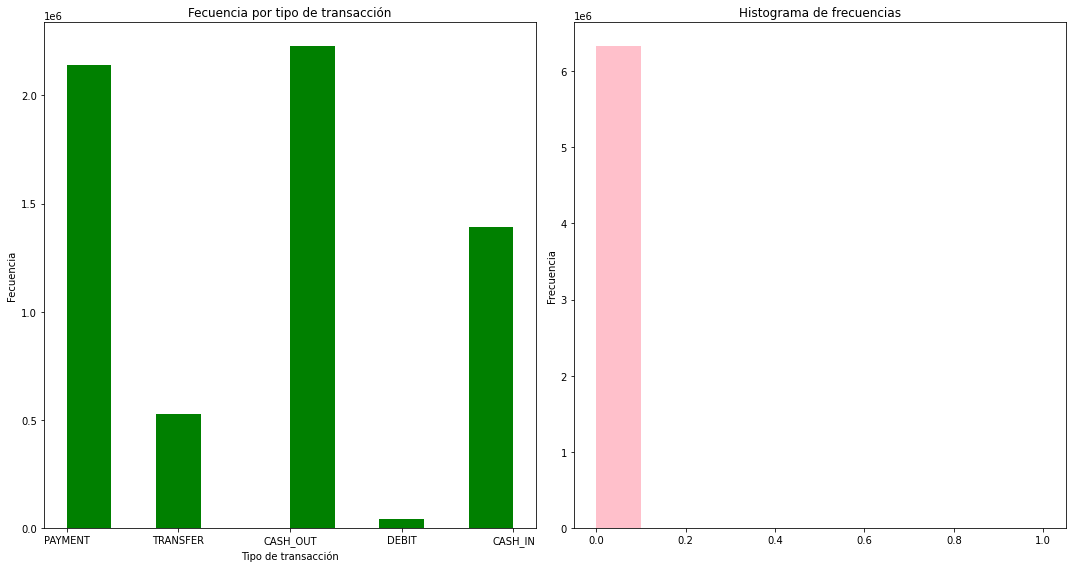

In [ ]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

#histogramas de frecuencias de FormaTx y Fraude
fig, axs = plt.subplots(1,2, tight_layout=True)
fig.set_size_inches((15,8))
plt.ylabel('Frecuencia')
axs[0].hist(bd2.FormaTx, density=False, color='g', )
axs[0].set_title('Fecuencia por tipo de transacción')
axs[0].set_xlabel('Tipo de transacción')
axs[0].set_ylabel('Fecuencia')
axs[1].hist(bd2.Fraude, density=False, color='pink')

plt.title('Histograma de frecuencias')

Respecto a la forma de las operaciones o movimientos, las más utilizadas son la salida de efectivo y la forma denominada pago, esta última, aunque no es una forma muy conocida, se mantendrá el nombre de la etiqueta y no se asumira que pueda tratarse a alguna de las otroas categorías dada la proporción de dicha forma de transacción. La entrada de efectivo también tiene una proporción de datos importantes y las operaciones débito son las de menor porpoción.

En cuanto al atributo Fraude, como era de esperarse se tienen un problema de desbalanceo de datos, donde la cantidad de operaciones identificadas como operaciones sospechosas es muy pequeña respecto al total de registros. A continuación se presenta la proporción de ambas categorias:

In [ ]:
#Proporción de operaciones sospechosas
m= (bd2[bd2['Fraude']==1].shape[0]/bd2.shape[0])*100
print(f'En la base de datos se tienen identificadas el {m}% de las operaciones como sospechosas y el {100-m}% son consideradas operaciones normales')

En la base de datos se tienen identificadas el 0.12951861484447338% de las operaciones como sospechosas y el 99.87048138515553% son consideradas operaciones normales


En el siguiente gráfico se representa la distribución de los datos para las variables: ValorTx, Saldo inicial y final del cliente, saldo inicial y final del beneficiario. En los 5 atributos se observa que en común la distribución de los datos está altamente concentrada a la izquierda y una larga cola a la derecha poco densa, indicativo de la presencia de valores atípicos de gran valor.

Text(0, 0.5, 'Distribución KDE')

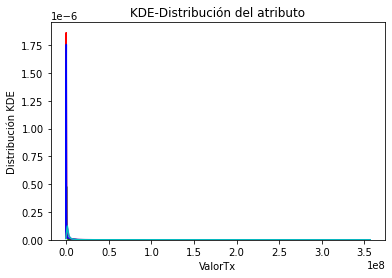

In [ ]:
#Distribución de los atributos numéricos o continuos

sns.kdeplot(bd2.ValorTx, color='g')
sns.kdeplot(bd2.SaldoIniCliente, color='r')
sns.kdeplot(bd2.SaldoFinCliente, color='b')
sns.kdeplot(bd2.SaldoIniBenef, color='m')
sns.kdeplot(bd2.SaldoFinBenef, color='c')

plt.title('KDE-Distribución del atributo')
plt.ylabel('Distribución KDE')

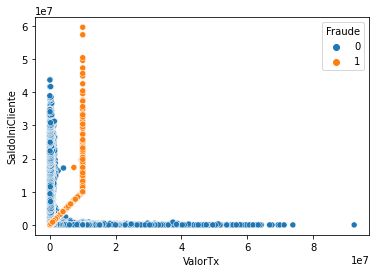

In [ ]:
#Distribución del valor de la transacción vs el saldo inicial del cliente clasificadas por el atributo Fraude
sns.scatterplot(x=bd2.ValorTx, y=bd2.SaldoIniCliente, hue=bd2.Fraude)

El gráfico de dispersión anterior nuevamente permite observa cómo se acumulan las operaciones en valores bajos y este último no está en función del saldo del cliente, es decir, un saldo inicial alto no implica que el valor del movimiento vaya a ser por en las mismas proporciones.

Dado que el gráfico permite observar la concentración de datos también en función de la clasificación dada a la operación encuanto a si fue una operación sospechosa o normal, es llamativo el comportamiento lineal que tiene las operaciones marcadas como sospechosas, lo cual puede deberse a que dicha clasificación fue realizada mediante la aplicación de reglas de negocio duras, es decir, basadas en un criterio atado a un valor de transacción.

## Correlación entre los atributos

Es importante saber si existe algún grado de correlación entre los diferentes atributos de la base datos, lo cual indicaría si el comportamiento o distribución de un atributo está afectado por otros atributos.

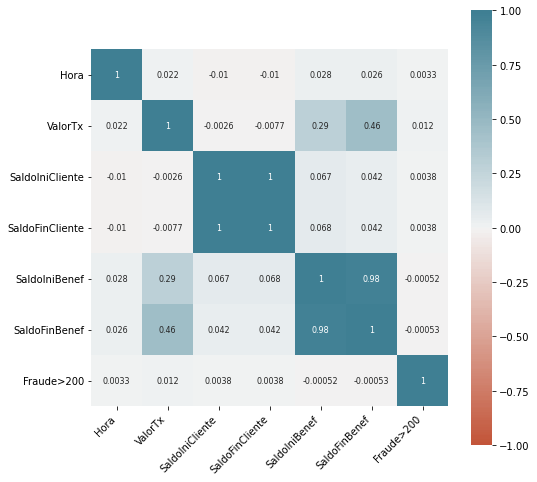

In [ ]:
#Cálculo de correlación entre variables o atributos
corr= bd2.corr()

#Gráfico de las correlaciones
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

sns.heatmap(corr,annot= True,cbar= True,annot_kws = {"size": 8},vmin= -1,vmax= 1,center= 0,cmap= sns.diverging_palette(20, 220, n=200),
    square= True,ax= ax)

ax.set_xticklabels(ax.get_xticklabels(),rotation = 45,horizontalalignment = 'right')

ax.tick_params(labelsize = 10)

Del resultado anterior se aprecia una fuerte correlación entre los saldos iniciales y finales para el cliente y para el beneficiario, esto posiblemente se deba a que la mayoría de las transacciones sean de valores pequeños; de hecho, la correlación entre los saldos y el valor de la transacción son muy débiles.

Pero teniendo en cuenta el gran desbalance que existe entre los datos de operaciones sospechosas vs las operaciones normales, a continuación se revisa la correlación entre las variables sólo para las operaciones sospechosas, donde se logra ver cómo aumenta el nivel de correlación del valor de la transacción con el saldo inicial del cliente y el saldo final del cliente

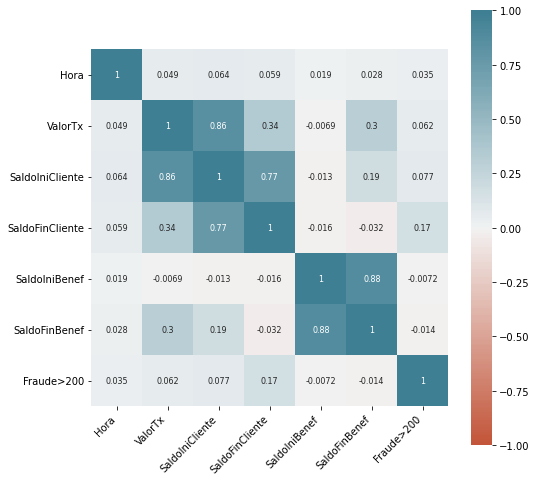

In [ ]:
#Cálculo de correlación entre variables o atributos
corr_f= bd2[bd2['Fraude']==1].corr()

#Gráfico de las correlaciones
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

sns.heatmap(corr_f,annot= True,cbar= True,annot_kws = {"size": 8},vmin= -1,vmax= 1,center= 0,cmap= sns.diverging_palette(20, 220, n=200),
    square= True,ax= ax)

ax.set_xticklabels(ax.get_xticklabels(),rotation = 45,horizontalalignment = 'right')

ax.tick_params(labelsize = 10)

# Transformación de Datos

## Detección y eliminación de valores atípicos

A continuación, se analizará la presencia de valores atípicos en cuada uno de los atributos, para lo cual no se tendrá en cuenta la variable 'Fraude>200' ya que el alcance de este proyecto no es detectar solo opereaciones sospechosos mayores a US$200.000 y la variable 'Hora' también se eliminará ya que no agrega valor al objetivo del proyecto.

In [ ]:
#Variables predictoras
data= bd2[['FormaTx',	'ValorTx',	'Cliente',	'SaldoIniCliente',	'SaldoFinCliente',	'Beneficiario',	'SaldoIniBenef',	'SaldoFinBenef', 'Fraude']]

Para la identificación de la presencia de valores atípicos, se acude al boxplot o caja de bigotes, el cual resume de manera visual la concentración/dispersión de los datos así como la presencia de datos atípicos o extremos

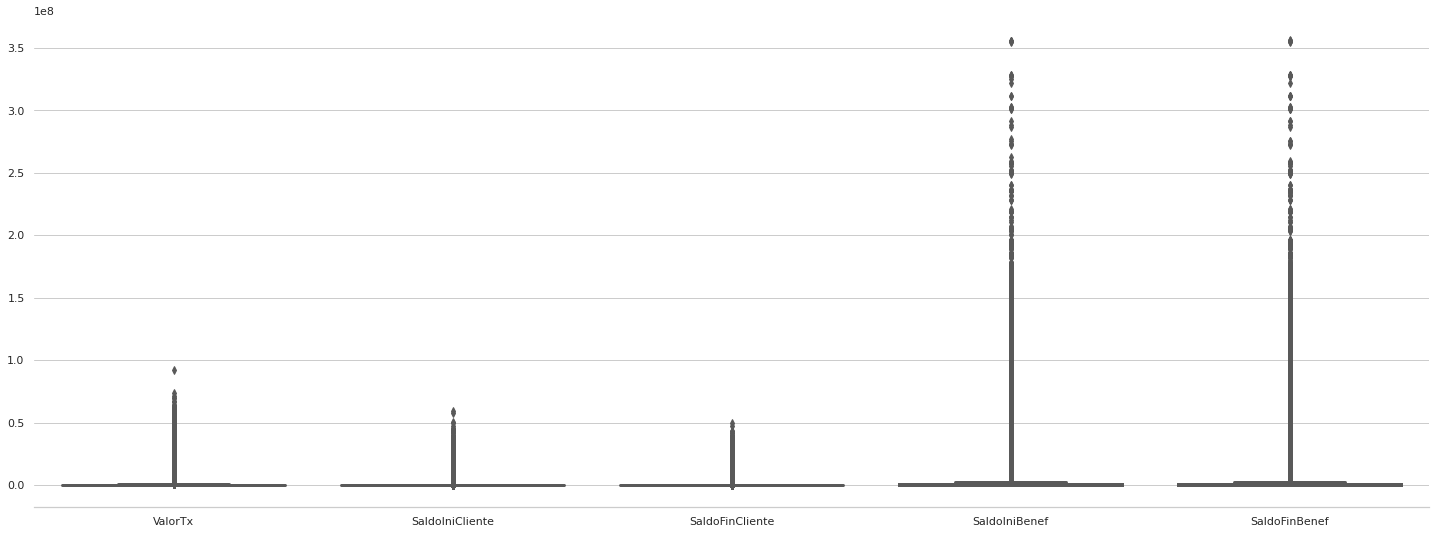

In [ ]:
#Identificación de valores atípicos

sns.set(rc={'figure.figsize':(25,9)}) # Tamaño de la figura
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = data, linewidth = 3, palette="Set2", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

En el gráfico anterior se observa la presencia de valores extremos o atípicos en los atributos numéricos a utilizar para el entrenamiento y validación del modelo, especialmente en los atributos del saldo inicial y final del destinatario o beneficiario de la operación.

Por lo tanto, se analizarán estos valores atípicos en dos momentos, en primer lugar  se analizaran los valores extremos del saldo de los beneficiarios mayores a $60 millions de dólares (umbral que está por encima de los valores atípicos de los demás atributos) y en segundo lugar se graficará nuevamente el bloxplot anterior sin los anteriores atípicos para analizar los valores atípicos persistentes.

In [ ]:
#Valores atípicos mayores a 60 Blln en los atributos de saldo del destinatario

outlier1= data[(data['SaldoIniBenef']>60000000)|(data['SaldoFinBenef']>60000000)]
print(f'La proporción de registros mayoes a 60 billions de dólares es del: {(outlier1.shape[0]/data.shape[0])*100}%')  #Porcentaje de datos atípicos
outlier1.describe()
#check= outlier1[outlier1['Fraude']==1.00] #Validación de los registros atípicos indentificados como operaciones sospechosas
#check

La proporción de registros mayoes a 60 billions de dólares es del: 0.04424205460101567%


,ValorTx,SaldoIniCliente,SaldoFinCliente,SaldoIniBenef,SaldoFinBenef
count,2.800000e+03,2.800000e+03,2.800000e+03,2.800000e+03,2.800000e+03
mean,9.030109e+06,9.186680e+05,9.409400e+05,8.899979e+07,1.001527e+08
std,1.421135e+07,3.098952e+06,3.150544e+06,4.736091e+07,4.571409e+07
min,7.488500e+02,0.000000e+00,0.000000e+00,0.000000e+00,5.937728e+07
25%,1.528013e+05,0.000000e+00,0.000000e+00,6.213405e+07,6.889101e+07
50%,3.926058e+05,0.000000e+00,0.000000e+00,7.573405e+07,8.375555e+07
75%,1.581643e+07,5.065375e+04,0.000000e+00,1.065861e+08,1.161060e+08
max,9.244552e+07,3.016004e+07,3.025661e+07,3.560159e+08,3.561793e+08


Se encontraron 2.800 registros con la condición anterior, equivalentes al 0,044% de los datos disponibles y de los cuales sólo dos registros fueron identificados como operaciones sospechosas con un valor de transacción inferior a los US$500.000. Por lo tanto, dada esta proporció se procede a eliminar estos datos de la base de datos.

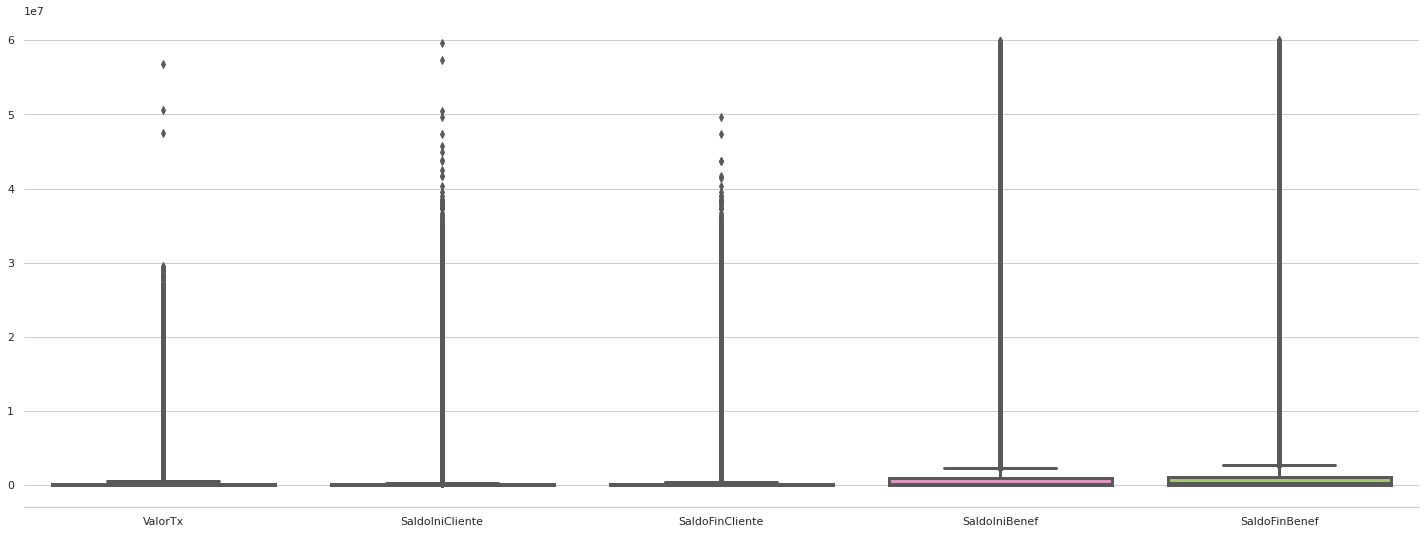

In [ ]:
#Primera depuración de valores atípicos
data= data[(data['SaldoIniBenef']<=60000000)&(data['SaldoFinBenef']<=60000000)]
#data.describe()

#Identificación de valores atípicos
sns.set(rc={'figure.figsize':(25,9)}) # Tamaño de la figura
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = data, linewidth = 3, palette="Set2", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

Ahora se determinará el rango intercuartílico IQR para la identificación y separación de los valores atípicos a depurar de la base de datos. En primer lugar se cualcular el IQR para cada variable y luego se filtran los valores atípicos extremos (3IQR) para revisar la proporción de datos y la cantidad de los mismos que fueron clasificados como operaciones sospechosas.
Mediante la validación de valores atípicos leves 1,5IQR se estarían eliminando el 63% de operaciones clasificadas como sospechosas y es por esta razón que no se aplica el criterio del 1,5IQR

In [ ]:
#rango intercuartílico de cada variable
item=['ValorTx',	'SaldoIniCliente',	'SaldoFinCliente',	'SaldoIniBenef',	'SaldoFinBenef']
dic_IQR={'Atributo':[],'minimo':[],'maximo':[]}  #Diccionario para almacenar los cuartiles de cada atributo

for i in item:
  q25,q75 = np.percentile(data[i].values, [25,75])
  iqr = q75 - q25
  dic_IQR['Atributo'].append(i)
  dic_IQR['minimo'].append(q25 - 3*iqr)
  dic_IQR['maximo'].append(q75 + 3*iqr)

#Dataframe con los rangos intercuartílicos para cada atributo
dic_IQR= pd.DataFrame(dic_IQR, index=range(len(item)))
dic_IQR 

,Atributo,minimo,maximo
0,ValorTx,-5.719795e+05,793776.65
1,SaldoIniCliente,-3.219810e+05,429308.00
2,SaldoFinCliente,-4.326956e+05,576927.43
3,SaldoIniBenef,-2.821227e+06,3761635.59
4,SaldoFinBenef,-3.326940e+06,4435919.57


In [ ]:
#Valores atípicos por fuera del rango IQR
outlier2= data[(data['ValorTx']<=dic_IQR.iloc[0,1])|(data['ValorTx']>=dic_IQR.iloc[0,2])|(data['SaldoFinCliente']<=dic_IQR.iloc[2,1])|(data['SaldoFinCliente']>=dic_IQR.iloc[2,2])|
                (data['SaldoIniBenef']<=dic_IQR.iloc[3,1])|(data['SaldoFinBenef']>=dic_IQR.iloc[3,2])|(data['SaldoIniCliente']<=dic_IQR.iloc[1,1])|(data['SaldoIniCliente']>=dic_IQR.iloc[1,2])|
                (data['SaldoFinBenef']<=dic_IQR.iloc[4,1])|(data['SaldoFinBenef']>=dic_IQR.iloc[4,2])]
outlier2.describe()

,ValorTx,SaldoIniCliente,SaldoFinCliente,SaldoIniBenef,SaldoFinBenef
count,1.442747e+06,1.442747e+06,1.442747e+06,1.442747e+06,1.442747e+06
mean,3.941794e+05,3.513893e+06,3.591618e+06,3.311527e+06,3.553653e+06
std,9.641649e+05,5.214722e+06,5.262663e+06,4.766153e+06,5.148119e+06
min,4.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.223365e+04,1.980400e+04,0.000000e+00,3.634015e+05,2.938886e+05
50%,1.677701e+05,1.062836e+06,1.194041e+06,1.425876e+06,1.593401e+06
75%,3.243423e+05,5.090829e+06,5.245125e+06,4.636189e+06,4.986123e+06
max,5.680898e+07,5.958504e+07,4.958504e+07,5.991943e+07,5.999275e+07


In [ ]:
check= outlier2[outlier2['Fraude']==1.00].shape[0]/ data[data['Fraude']==1.00].shape[0]*100 #Validación de los registros atípicos indentificados como operaciones sospechosas
check

52.25137278828554

Los resultados de la técnica de identificación de datos atípicos extremos con el rango intercuartílico, se detectaron 1.442.747 observaciones atípicas, entre las cuales se estaría eliminando el 52,3% de las operaciones sospechosas disponibles para desarrollar el modelo de clasificación de operaciones de lavado de dinero.

Por lo anterior, lo recomendable será la aplicacón de un método de detección de valores atípicos no supervisado como el factor atípico local o LOF.

In [ ]:
from sklearn.neighbors import LocalOutlierFactor # detección de outlers no supervisado basado en LOF
from matplotlib import pyplot

LOF = LocalOutlierFactor(n_neighbors = 5, algorithm = 'auto', metric = 'euclidean') 
Filtrado = LOF.fit_predict(data[item]) # Se realiza la predicción de los datos atípicos
NOF = LOF.negative_outlier_factor_ # Detecta los valores positivos y negativos (residuos). Si los valores son grandes, entonces son valores no atípicos y por lo general, son valores cercanos a -1.
                                   # Si los valores son positivos y grandes y cercanos a 1, entonces son valores atípicos. La opción negative_outlier_dactor_ calcula dichos valores por 
                                   # la media de la relación entre la densidad local de una muestra y las de sus vecinos más cercanos.

radio_outiler = (NOF.max() - NOF)/(NOF.max() - NOF.min()) # radio de detección de datos atípicos
ground_truth = np.ones(len(data[item]), dtype = int) # Se recomienda para luego comparar que datos es o no atípico (genera un vector de 1 o -1)
n_errors = (Filtrado != ground_truth).sum() # número de datos atípicos

In [ ]:
print("Detección: ", Filtrado)
print("Factores atípicos negativos: ", NOF)
print("Número de muestras o filas con datos atípicos: ", n_errors)

Detección:  [1 1 1 ... 1 1 1]
Factores atípicos negativos:  [-1.0282857  -0.9458225  -1.0522376  ... -1.04181285 -1.0253392
 -1.30006219]
Número de muestras o filas con datos atípicos:  186527


Con este método se identificaron 186527 registros con valores atípicos, de los cuales 378 registros corresponden a operaciones sospechosas equivalentes a un 4,6% del total de operaciones sospechosas de la base de datos.

In [ ]:
#Valores atípicos detectados con el método no supervisado LOF
pos = np.where(Filtrado != ground_truth) # Observaciones marcadas como valores atípicos
pos = np.asarray(pos)
pos = np.hstack(pos)
outilers_LOF = data.iloc[pos, :]
print("Número outilers:", outilers_LOF.shape[0])
print('Númer de operaciones sospechosas como outliers',outilers_LOF[outilers_LOF['Fraude']==1].shape[0],'equivalente al: ',
      (outilers_LOF[outilers_LOF['Fraude']==1].shape[0]/data[data['Fraude']==1].shape[0])*100,'% del total de operaciones sospechosas' )

Número outilers: 186527
Númer de operaciones sospechosas como outliers 378 equivalente al:  4.6125686394142775 % del total de operaciones sospechosas


Se procede a eliminar los valores atípicos obtenidos con el método LOF de la base de datos y se grafican nuevamente los boxplot para comprobar la distribución de los atributos luego de eliminar los datos atípicos.

In [ ]:
#Eliminación de datos atípicos
pos = np.where(Filtrado == ground_truth) 
pos = np.asarray(pos)
pos = np.hstack(pos)
data = data.iloc[pos, :]
print("Número de operaciones sin outilers:", data.shape[0])

data.describe()

Número de operaciones sin outilers: 6139493


,ValorTx,SaldoIniCliente,SaldoFinCliente,SaldoIniBenef,SaldoFinBenef
count,6.139493e+06,6.139493e+06,6.139493e+06,6.139493e+06,6.139493e+06
mean,1.730712e+05,8.317682e+05,8.531509e+05,1.041262e+06,1.157137e+06
std,4.835390e+05,2.881555e+06,2.917129e+06,2.618571e+06,2.811144e+06
min,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.322800e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.373191e+04,1.473800e+04,0.000000e+00,1.275395e+05,2.082300e+05
75%,2.068659e+05,1.077720e+05,1.461970e+05,9.215355e+05,1.087422e+06
max,2.958170e+07,5.039905e+07,4.039905e+07,5.990727e+07,5.999275e+07


In [ ]:
#Se resetea los índices de la base de datos resultante
data.reset_index(drop=True, inplace=True)
#data

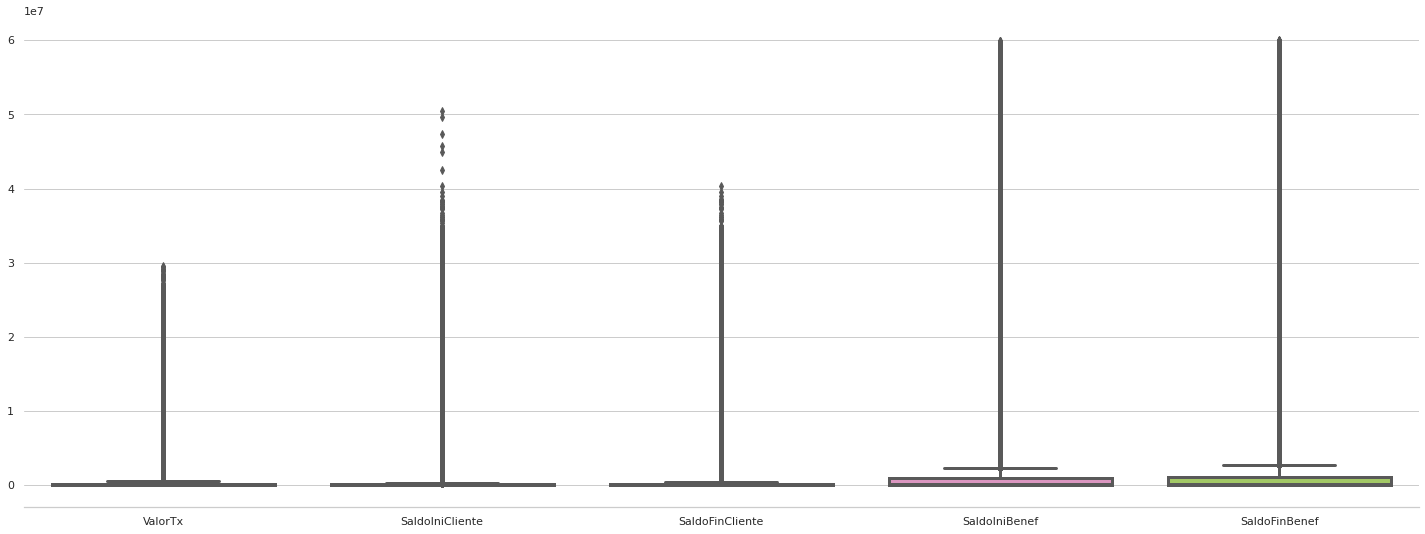

In [ ]:
#Boxplot de datos
sns.set(rc={'figure.figsize':(25,9)}) # Tamaño de la figura
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = data, linewidth = 3, palette="Set2", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

Como se puede observar en la gráfica anterior, aparentemente siguen conservandose muchos datos que parecieran ser valores extremos pero como se mencionó en las últimas líneas, no se pueden eliminar ya que se eliminaría gran catidad de datos importantes para el entrenamiento del modelo en la identificación de operaciones sospechosas. En su lugar, lo que se debará hacer es seleccionar métodos y algoritmos adecuados para trabajar con datos con alta presencia de valores atípicos o extremos.

## Imputación de valores faltantes

Para este proyecto no será nocesario aplicar técnicas de imputación de datos faltantes ya que como se evidenció en este análisis exploratorio de datos, no se cuenta con valores nulos o faltantes.

## Escalado de datos

Dada la alta cantidad de valores atípicos que pueden haber quedado en la base de datos después de aplicar el tratamiento anterior, lo mejor es realizar el escalado de lo datos aplicando un método de escalamiento robusto el cual utilizará el rango de intercuartiles para dicho escalamiento.

Como este método requiere un rango intercuartílico para escalar los datos, se realizará el escalado con tres rangos intercuartílicos para dejar aquel que logre la mayor reducción de la escalaridad de los datos.

In [ ]:
from sklearn.preprocessing import RobustScaler # Escalamiento robusto

data_1 = RobustScaler(quantile_range = (20, 70)) # (Primer cuartil, tercer cuartil)
data_2 = RobustScaler(quantile_range = (25, 75))
data_3 = RobustScaler(quantile_range = (30, 80))

dataEsc_1 = data_1.fit_transform(data[item])
dataEsc_2 = data_2.fit_transform(data[item])
dataEsc_3 = data_3.fit_transform(data[item])

In [ ]:
#Resultado del escalado
dataEsc_1 = pd.DataFrame(data = dataEsc_1, columns = item)
dataEsc_2 = pd.DataFrame(data = dataEsc_2, columns = item)
dataEsc_3 = pd.DataFrame(data = dataEsc_3, columns = item)

A continuación se observa los resultados de los tres escalados mediante la dispersión de los datos en los boxplots

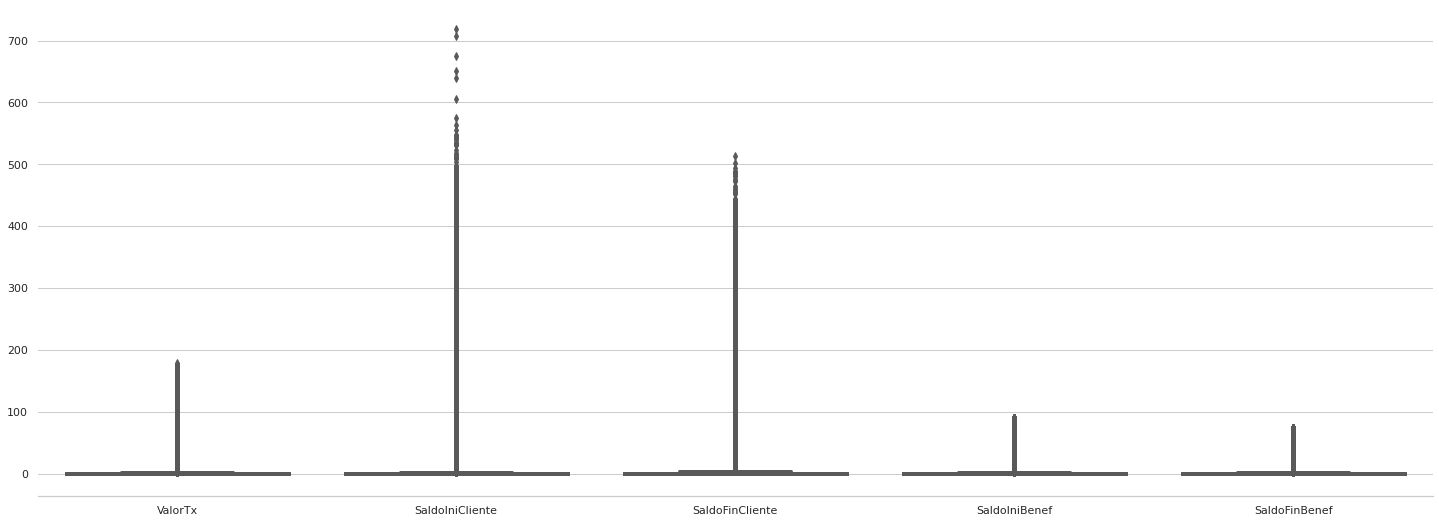

In [ ]:
#Escalado rango intercuartílico 20,70
sns.set(rc={'figure.figsize':(25,9)}) # Tamaño de la figura
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = dataEsc_1, linewidth = 3, palette="Set2", fliersize = 5)
sns.despine(left=True)

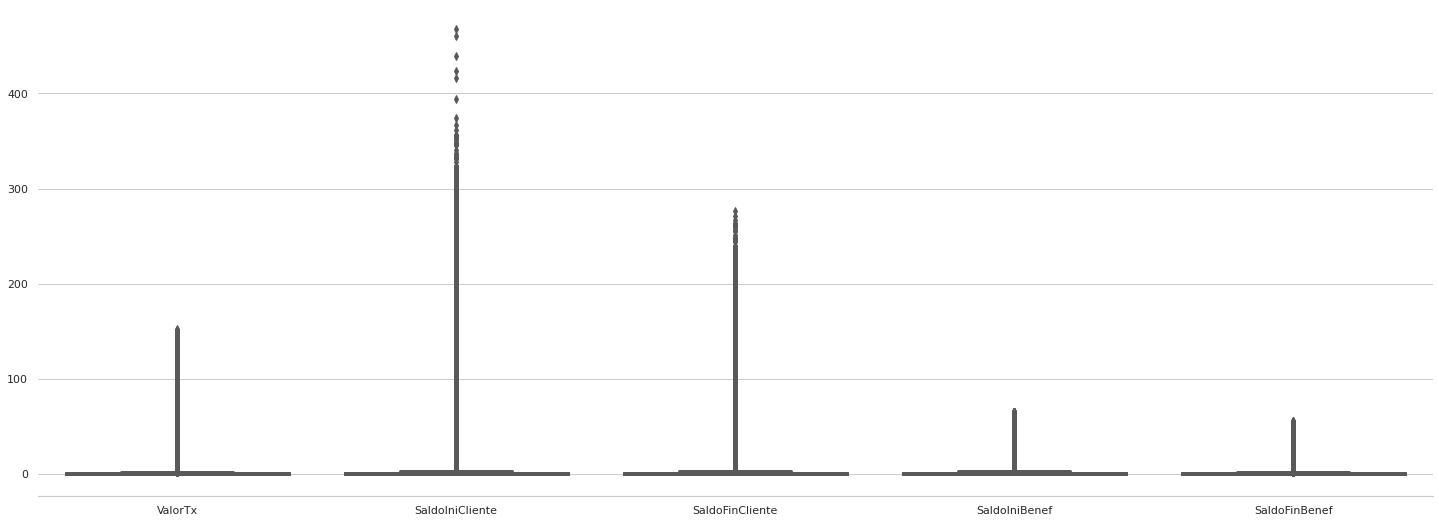

In [ ]:
#Escalado rango intercuartílico 25,75
sns.set(rc={'figure.figsize':(25,9)}) # Tamaño de la figura
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = dataEsc_2, linewidth = 3, palette="Set2", fliersize = 5)
sns.despine(left=True)

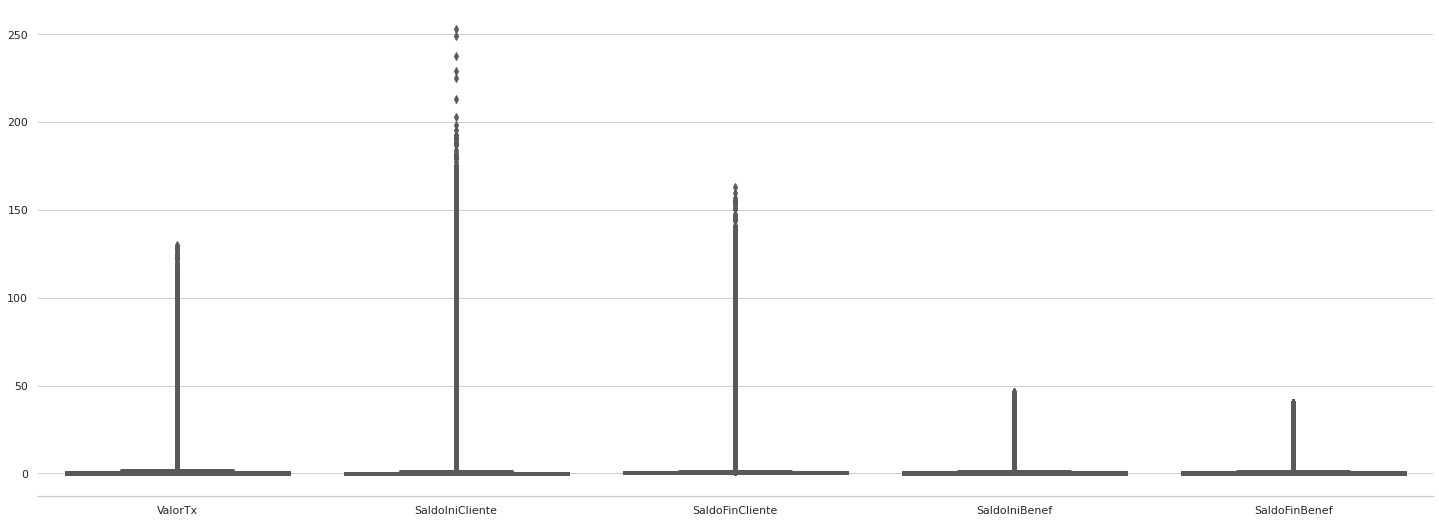

In [ ]:
#Escalado rango intercuartílico 30,80
sns.set(rc={'figure.figsize':(25,9)}) # Tamaño de la figura
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = dataEsc_3, linewidth = 3, palette="Set2", fliersize = 5)
sns.despine(left=True)

De los tres rango intercuartílicos anteriores, el rango (30,80) es el que ofrece la mayor reducción de escalaridad de los datos.

## Encoding

El atributo **FormaTx** es una variable categórica nominal que indica la forma como fue realizada la operación, es decir, en efectivo, transferencia electrónica o cualquier otra forma disponible en la entidad financiera para el movimiento de dinero.

Como bien es sabido en la literatura sobre el lavado de dinero, hay unas formas de pago o movimiento de dinero que facilitan en mayor medida el movimiento de recursos ilícitos, por ejemplo, el dinero en efectivo o cash se presta en mayor medida para la comisión de dichos ilícitos por la dificultad en rastrear la procedencia de dichos ilícitos y de tener la trazabilidad de sus movimientos; mientras que las transferencias electrónicas brindan mayor trazabiliad de los movimientos y mayor control a la realización de los mismos.

Por lo anterior, la forma de la transacción es un atributo que puede ser de importancia para la identificación de las operaciones sospechosas de lavado de dinero y para que cualquier modelo pueda procesar dicha información, es necesario convertir la información en valores procesables por los mismos mediante la aplicación de una técnica de enconding.

Los valores de la etiquetas de este atributo son los siguientes:

In [ ]:
#Etiquetas del atributo FormaTx
FormaTx = list(data['FormaTx'].value_counts().index)
print('Los valores del atributo FormaTx son: ',FormaTx)

Los valores del atributo FormaTx son:  ['CASH_OUT', 'PAYMENT', 'CASH_IN', 'TRANSFER', 'DEBIT']


Como se puede apreciar en la línea anterior, el atributo FormaTx posee cinco etiquetas: Débito, transferencia, pago, entrada y salida en efectivo. Con el fin de reducir un poco la dimensionalidad y teniendo en cuenta que no es una variable nominal oridinal, se aplicará la técnica dummy la cual codifica sólo cuatro variables.

In [ ]:
#Codificación del atributo FormaTx
data_dummy = pd.get_dummies(data['FormaTx'], drop_first = True)
display(data_dummy)

,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0,0,1,0
1,0,0,1,0
2,0,0,0,1
3,1,0,0,0
4,0,0,1,0
...,...,...,...,...
6139488,1,0,0,0
6139489,0,0,0,1
6139490,1,0,0,0
6139491,0,0,0,1


Finalmente, luego de aplicar las tarformaciones anteriores, se concatena los atributos codificados con los datos escalados

In [ ]:
#Concatenación de la base de datos
data2= pd.concat([data_dummy,dataEsc_3,data['Fraude']],axis=1,)
data2.tail()

,CASH_OUT,DEBIT,PAYMENT,TRANSFER,ValorTx,SaldoIniCliente,SaldoFinCliente,SaldoIniBenef,SaldoFinBenef,Fraude
6139488,1,0,0,0,1.174029,1.631229,0.0,-0.098738,0.088601,1
6139489,0,0,0,1,27.536028,31.609478,0.0,-0.098738,-0.140350,1
6139490,1,0,0,0,27.536028,31.609478,0.0,-0.045715,4.159791,1
6139491,0,0,0,1,3.426822,4.193053,0.0,-0.098738,-0.140350,1
6139492,1,0,0,0,3.426822,4.193053,0.0,4.941213,4.820462,1


## Reducción de dimensionalidad con PCA-Incremental

Por el tamaño de la base de datos, lo más recomendable es utilizar la técnica de reducción de dimensionalidad PCA de manera incremental para optimizar el uso de memoria.

Pero en primer lugar, se determina el número óptimo de componentes:

In [ ]:
#Separación de la variable objetivo para aplicar el PCA
Data_X= data2.iloc[:,0:9]
Data_Y= data2['Fraude']

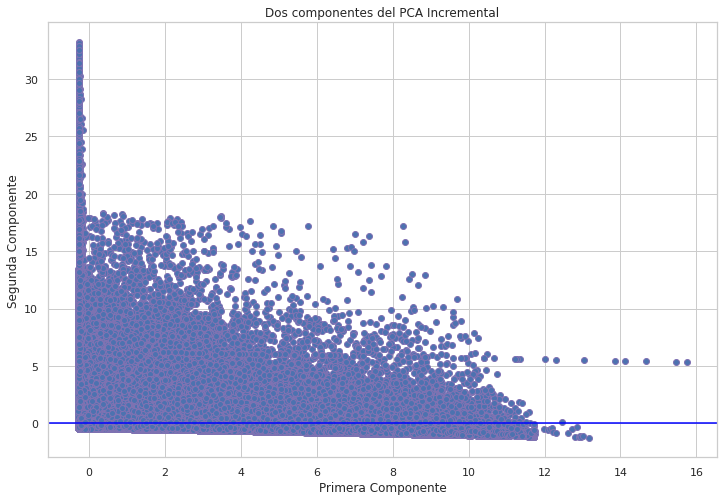

In [ ]:
#Aplicación de PCA Incremental para identificar el número de componentes óptimo

from sklearn.decomposition import IncrementalPCA # Cargamos el método PCA incremental
from matplotlib import pyplot

PCA_inc = IncrementalPCA(n_components = 9, whiten = True, batch_size = 100000)

Variables_Principales_IPCA = PCA_inc.fit_transform(Data_X) # Transformarmos las componentes principales a partir de los datos
#Variables_Principales_IPCA

#Gráfico de las componentes principales
fig = pyplot.figure(figsize=(12,8)) 
pyplot.scatter(Variables_Principales_IPCA[:,0], Variables_Principales_IPCA[:,1], edgecolors="m")
pyplot.axhline(0, color="blue")
pyplot.title('Dos componentes del PCA Incremental')
pyplot.xlabel('Primera Componente')
pyplot.ylabel('Segunda Componente')
pyplot.show()

A continuación se calcula la tasa de varianza explicada para cada una de las compononentes principales del modelo PCA de reducción así como su importancia para el modelo, datos con los cuales se seleccinará el número óptimo de componentes a los cuales se reducirá la dimensionalidad.

(0.0, 9.0)

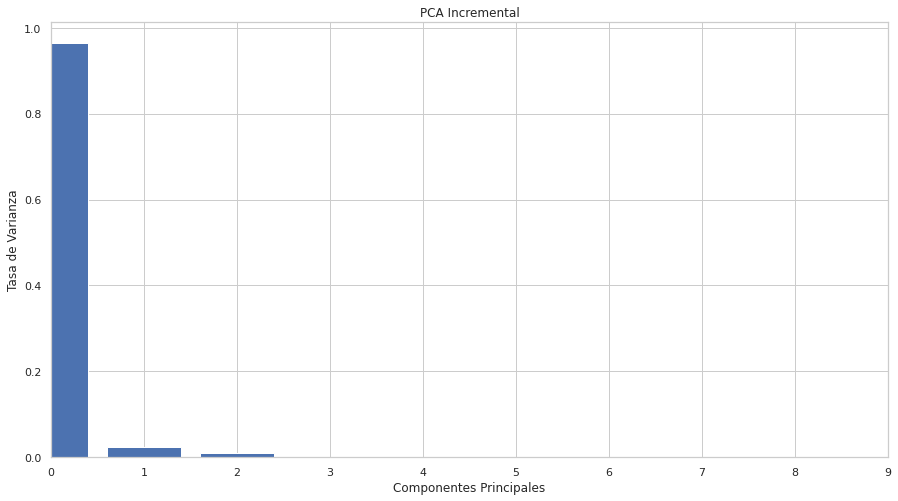

In [ ]:
# Cálculo de la tasa de varianza de las componentes
Varianza_PCAinc = PCA_inc.explained_variance_ratio_ 
Valores_Singulares_PCAinc = PCA_inc.singular_values_

fig = pyplot.figure(figsize=(15,8))
pyplot.bar(np.arange(len(Varianza_PCAinc)), Varianza_PCAinc)
pyplot.xlabel('Componentes Principales')
pyplot.ylabel('Tasa de Varianza')
pyplot.title('PCA Incremental')
pyplot.xlim(0, len(Varianza_PCAinc))

In [ ]:
Importancia_Componentes = pd.DataFrame(data = Varianza_PCAinc)
Importancia_Componentes = Importancia_Componentes.T
print("Porcentaje de Varianza detectada para las primeras 3 componentes: ", format(100*Importancia_Componentes.loc[:,0:2].sum(axis = 1).values))
print("Porcentaje de Varianza detectada para las primeras 6 componentes: ", format(100*Importancia_Componentes.loc[:,0:5].sum(axis = 1).values))
print("Porcentaje de Varianza detectada para las primeras 10 componentes: ", format(100*Importancia_Componentes.loc[:,0:9].sum(axis = 1).values))

Porcentaje de Varianza detectada para las primeras 3 componentes:  [99.80619453]
Porcentaje de Varianza detectada para las primeras 6 componentes:  [99.98167411]
Porcentaje de Varianza detectada para las primeras 10 componentes:  [100.]


En los resultados anteriores se aprecia claramente cómo las tres primeras componentes recopilan el 99,8% de la información de mayor relevancia para el PCA incremental en la reducción de dimensionalidad. Por lo tanto, se selecciona este valor como el número óptimo de componentes.
A continuación ya se debe aplicar el PCA Clásico

In [ ]:
#Transformación de los datos a tres componentes principales
from sklearn.decomposition import PCA

Tasa_Varianza_Explicada = np.sum(Varianza_PCAinc[0:3])
Nuevas_Componentes = PCA(Tasa_Varianza_Explicada, random_state = 17, svd_solver='auto', tol = 1e-3, whiten = False)

Datos_Reducidos_incPCA = Nuevas_Componentes.fit_transform(Data_X) 

print('Tamaño de los datos originales: ', Data_X.shape,'Tamaño de los datos reducidos: ', Datos_Reducidos_incPCA.shape) 
print("Porcentaje de la varianza explicada con las componentes seleccionadas: {:.2f}%".format(Tasa_Varianza_Explicada*100))

Tamaño de los datos originales:  (6139493, 9) Tamaño de los datos reducidos:  (6139493, 3)
Porcentaje de la varianza explicada con las componentes seleccionadas: 99.81%


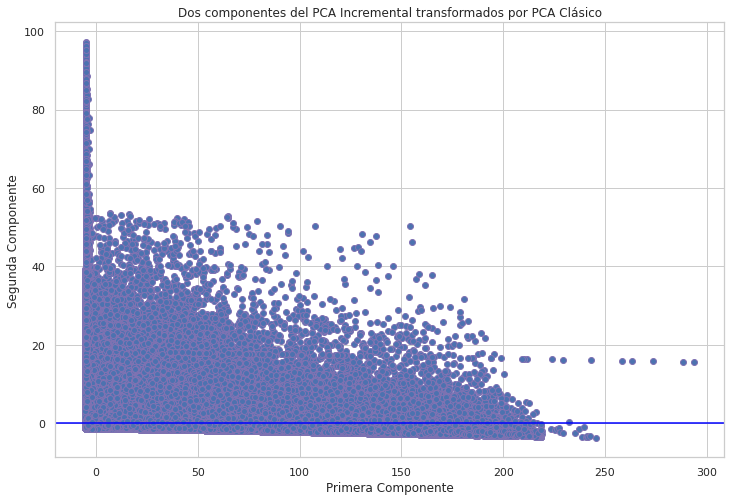

In [ ]:
#Gráfico de los datos reducidos a tres componentes
fig = pyplot.figure(figsize=(12,8)) # Se define el tamaño de la figura en ancho y altura

pyplot.scatter(Datos_Reducidos_incPCA[:,0], Datos_Reducidos_incPCA[:,1], edgecolors="m")
pyplot.axhline(0, color="blue")
pyplot.title('Dos componentes del PCA Incremental transformados por PCA Clásico')
pyplot.xlabel('Primera Componente')
pyplot.ylabel('Segunda Componente')
pyplot.show()

Ahora ya se tiene la base de datos reducida de 9 atributos predictores a sólo tres y adicionalmente se separó el atributo target de los demás atributos. Lo que se hará es llamar nuevamente Data_X a los datos reducidos con el fin de seguir utilizando este nombre en los modelos.

In [ ]:
Data_X= Datos_Reducidos_incPCA
Data_X.shape

(6139493, 3)

In [ ]:
Data_X

array([[-4.35332804, -1.32343749, -0.16365048],
       [-5.29173556, -1.33002976, -0.20083279],
       [-5.41942904, -1.25157578, -0.14971746],
       ...,
       [19.17137423, 13.7355548 , 24.25174085],
       [-2.11114729,  0.39847828,  3.26922874],
       [-2.03711697,  6.70241557,  0.0652199 ]])

In [ ]:
#Se exporta las variables con reducción de dimensionalidad
pd.DataFrame(Data_X).to_csv('Data_X.csv')

In [ ]:
#Se exporta la variable objetivo
Data_Y.to_csv('Data_Y.csv')